In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

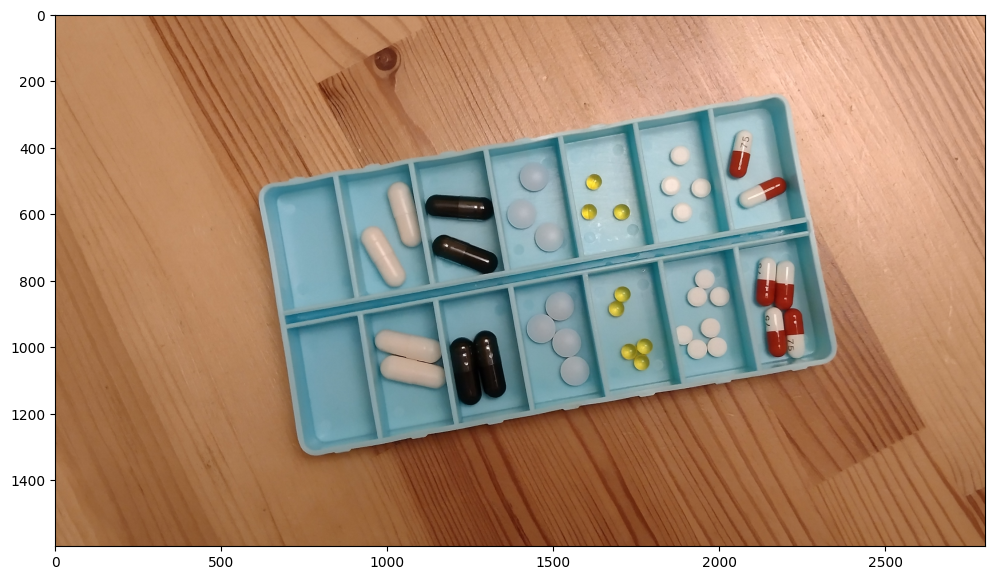

In [2]:
calib = cv2.imread('calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

In [3]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

In [4]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [5]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

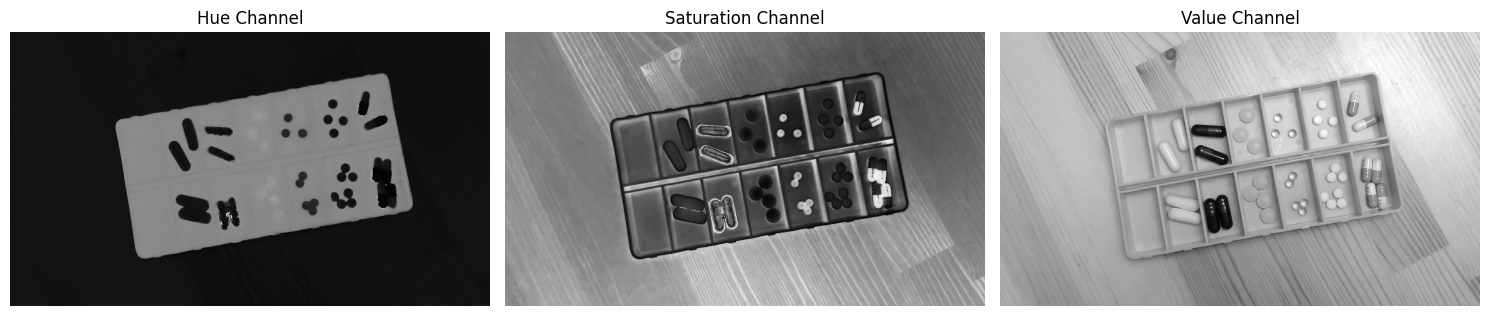

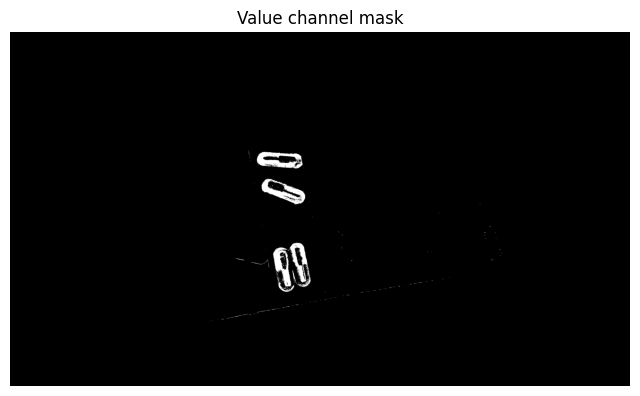

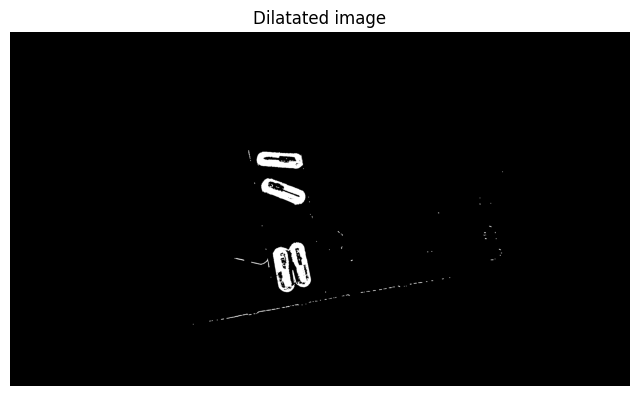

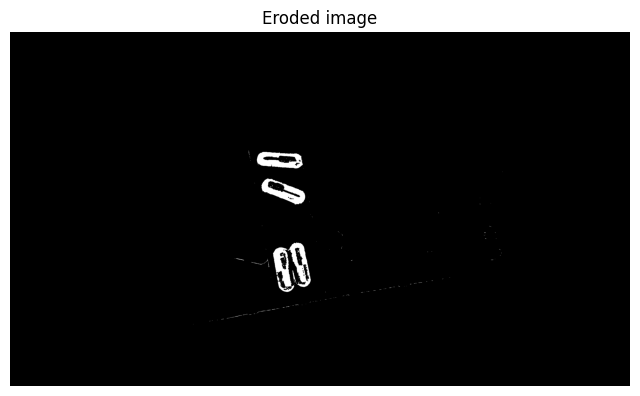

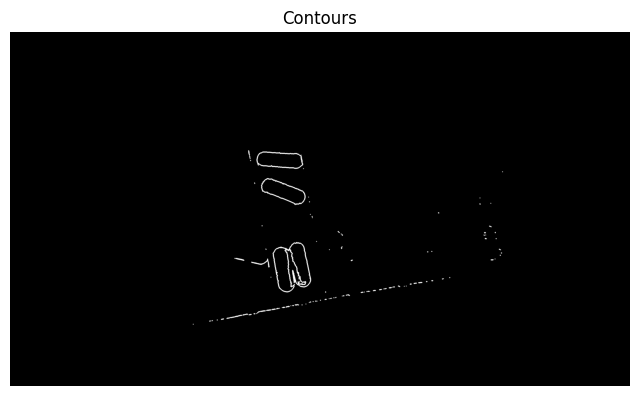

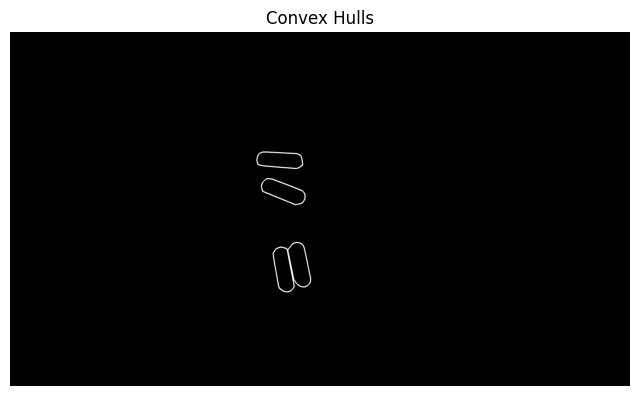

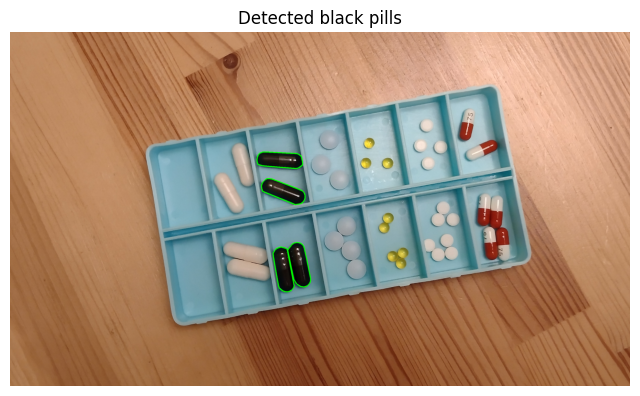

In [6]:
def create_pills_from_contours(contours, pill_type):
        detected_pills: List[Pill] = []

        for contour in contours:
            location = contour
            detected_pills.append(Pill(pill_type, location))
        
        return detected_pills

def black_pill_binarizer(image: np.ndarray, display: bool = False) -> np.ndarray:
    original_image = image.copy()
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # hsv channels
    h_channel, s_channel, v_channel = cv2.split(image_hsv)
    if display:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(h_channel, cmap="gray")
        plt.title("Hue Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(s_channel, cmap="gray")
        plt.title("Saturation Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(v_channel, cmap="gray")
        plt.title("Value Channel")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

    # FOR MASK
    lower_bound = 15
    upper_bound = 38
    value_mask = cv2.inRange(v_channel, lower_bound, upper_bound)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(value_mask, cmap="gray")
        plt.title("Value channel mask")
        plt.axis("off")
        plt.show()
    image = value_mask

    # Apply dilatation
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap="gray")
        plt.title("Dilatated image")
        plt.axis("off")
        plt.show()
    

    # Apply erosion
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap="gray")
        plt.title("Eroded image")
        plt.axis("off")
        plt.show()
    

    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if display:
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, contours, -1, (255, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        plt.title("Contours")
        plt.axis("off")
        plt.show()

    # Convex hull
    convex_hulls = []
    for contour in contours:
        hull = cv2.convexHull(contour)
        convex_hulls.append(hull)

    # filter convex hulls
    min_area = 200  # Minimum area threshold
    filtered_hulls = [hull for hull in convex_hulls if cv2.contourArea(hull) > min_area]
    convex_hulls = filtered_hulls

    if display:
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, convex_hulls, -1, (255, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        plt.title("Convex Hulls")
        plt.axis("off")
        plt.show()

    # Convex hull on orginal image
    if display:
        convex_hull_image = original_image.copy()
        cv2.drawContours(convex_hull_image, convex_hulls, -1, (0, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(convex_hull_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected black pills")
        plt.axis("off")
        plt.show()
        
    return convex_hulls
    


carbon = create_pills_from_contours(
        black_pill_binarizer(calib, True), PillType.CARBON
    )

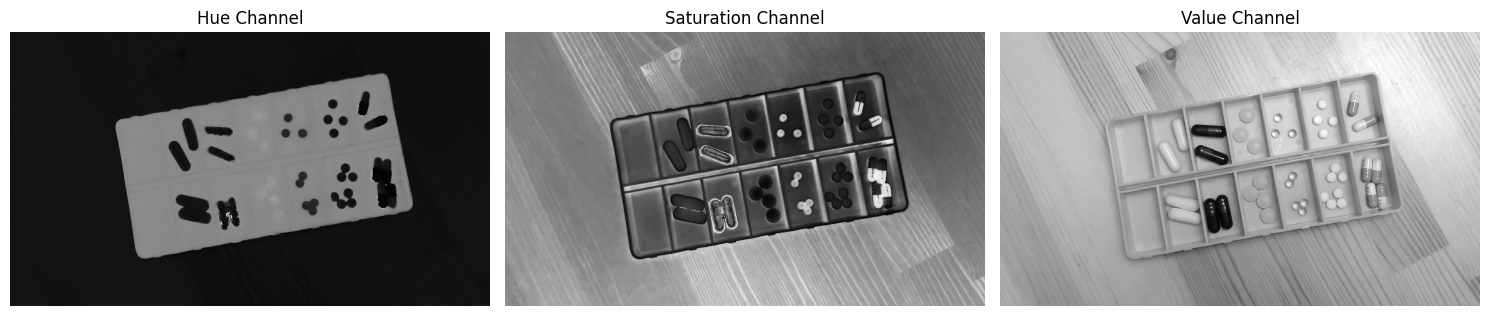

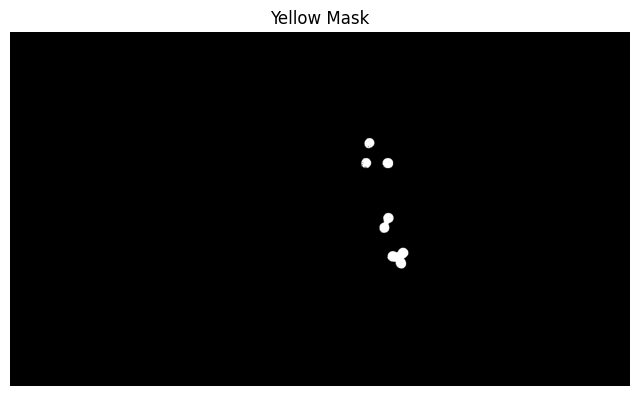

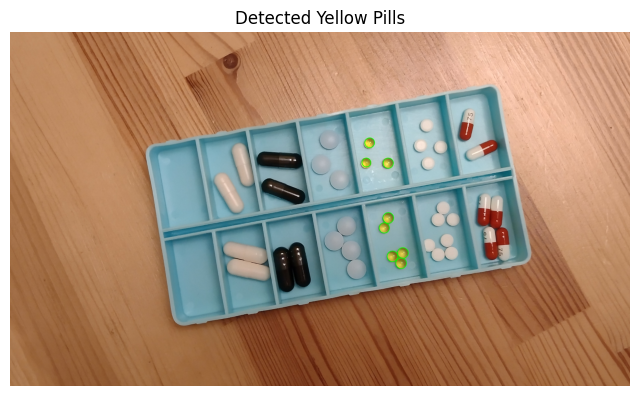

In [7]:
def yellow_pills_binarizer(image: np.ndarray, display: bool = False) -> np.ndarray:
    # Konwersja do HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Badanie kanałów
    h_channel, s_channel, v_channel = cv2.split(image_hsv)

    if display:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(h_channel, cmap="gray")
        plt.title("Hue Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(s_channel, cmap="gray")
        plt.title("Saturation Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(v_channel, cmap="gray")
        plt.title("Value Channel")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()


    # Maska
    lower_yellow = np.array([25, 100, 50])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(image_hsv, lower_yellow, upper_yellow)

    
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(yellow_mask, cmap="gray")
        plt.title("Yellow Mask")
        plt.axis("off")
        plt.show()

    # transformacja Hougha
    circles = cv2.HoughCircles(
        yellow_mask,
        cv2.HOUGH_GRADIENT,
        dp=1.5,
        minDist=20,
        param1=50,
        param2=15,
        minRadius=15,
        maxRadius=30,
    )

    detected_circles = []  # Lista wykrytych okręgów

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for x, y, r in circles:
            detected_circles.append((x, y, r))  # Przechowywanie środka i promienia okręgu

        # Wizualizacja wykrytych okręgów
        if display:
            output_image = image.copy()
            for x, y, r in detected_circles:
                cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Rysowanie okręgu
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
            plt.title("Detected Yellow Pills")
            plt.axis("off")
            plt.show()

    # Transform circles to contour
    contours = []
    for x, y, r in circles:
            # Create a circular contour
            contour = np.array(
                [
                    [x + r * np.cos(theta), y + r * np.sin(theta)]
                    for theta in np.linspace(0, 2 * np.pi, 100)
                ],
                dtype=np.int32,
            )
            contours.append(contour)

    return contours


espu = create_pills_from_contours(
        yellow_pills_binarizer(calib, True), PillType.ESPU
    )

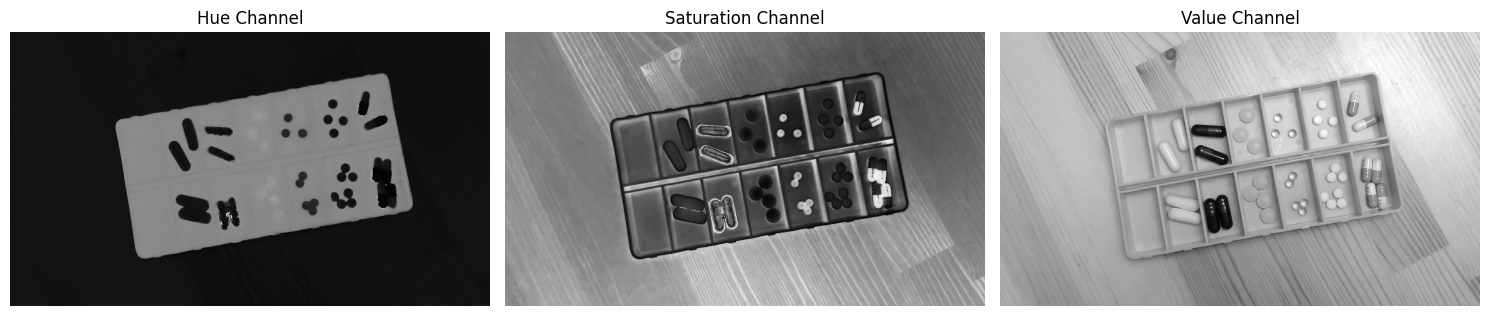

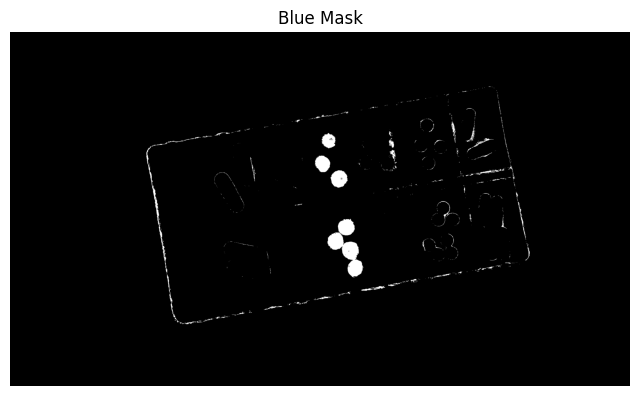

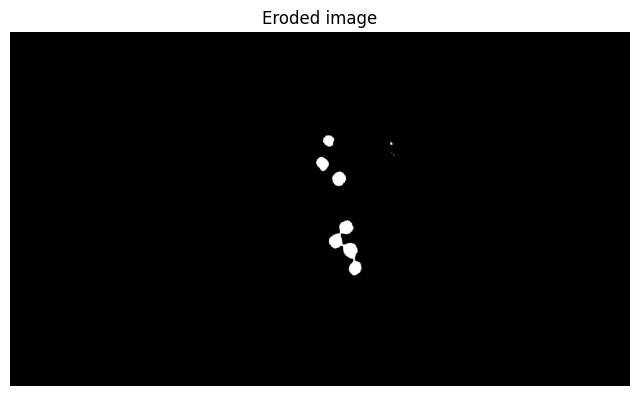

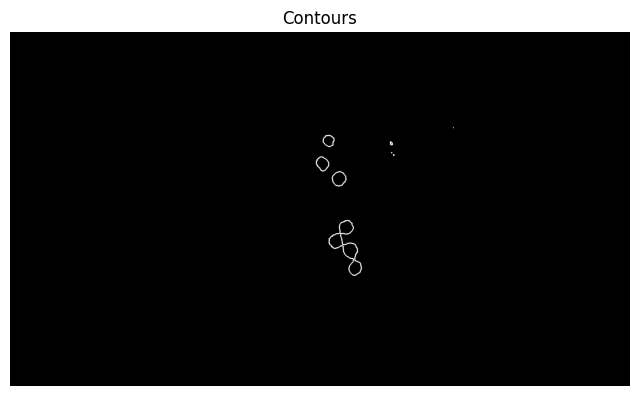

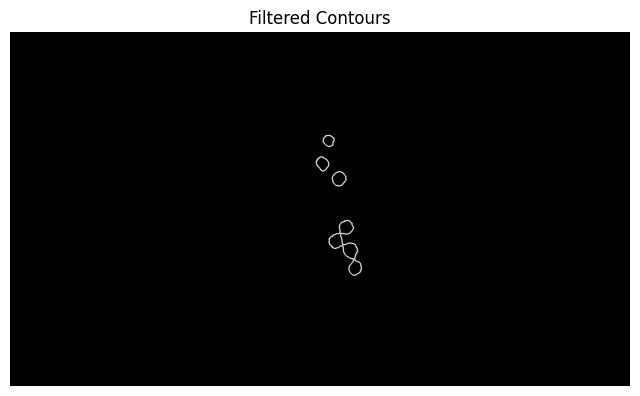

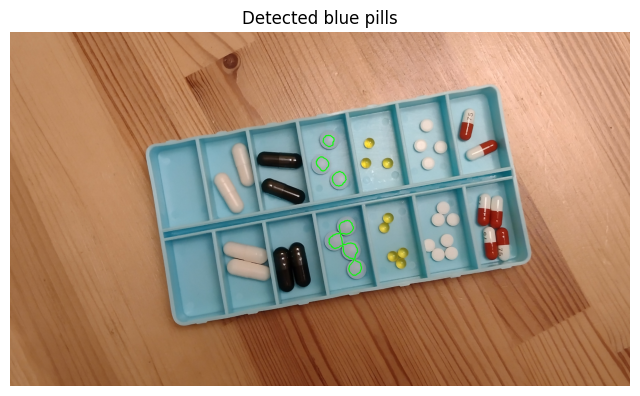

In [8]:
def blue_pills_binarizer(image: np.ndarray, display: bool = False) -> List[np.ndarray]:
    original_image = image.copy()
    # Konwersja do HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Badanie kanałów
    h_channel, s_channel, v_channel = cv2.split(image_hsv)

    if display:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(h_channel, cmap="gray")
        plt.title("Hue Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(s_channel, cmap="gray")
        plt.title("Saturation Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(v_channel, cmap="gray")
        plt.title("Value Channel")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

    # Maska
    lower_blue = np.array([90, 0, 130])
    upper_blue = np.array([120, 30, 200])
    blue_mask = cv2.inRange(image_hsv, lower_blue, upper_blue)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(blue_mask, cmap="gray")
        plt.title("Blue Mask")
        plt.axis("off")
        plt.show()
    image = blue_mask

    
    # Apply erosion
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=6)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap="gray")
        plt.title("Eroded image")
        plt.axis("off")
        plt.show()
    
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if display:
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, contours, -1, (255, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        plt.title("Contours")
        plt.axis("off")
        plt.show()
        
    # Filtrowanie konturów na podstawie ich obszaru
    min_area = 200
    filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt)]
    if display:
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        plt.title("Filtered Contours")
        plt.axis("off")
        plt.show()

    if display:
        cv2.drawContours(original_image, filtered_contours, -1, (0, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected blue pills")
        plt.axis("off")
        plt.show()

    return filtered_contours


keto = create_pills_from_contours(blue_pills_binarizer(calib, True), PillType.KETO)

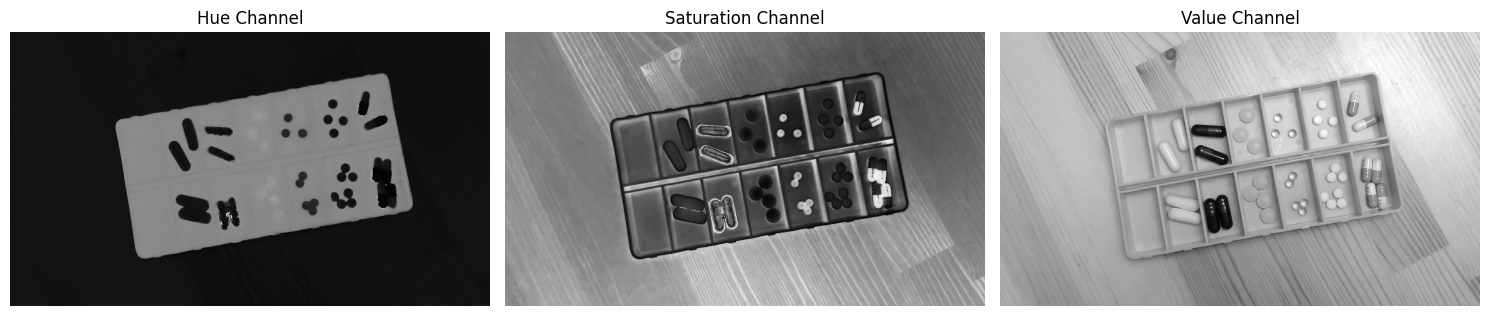

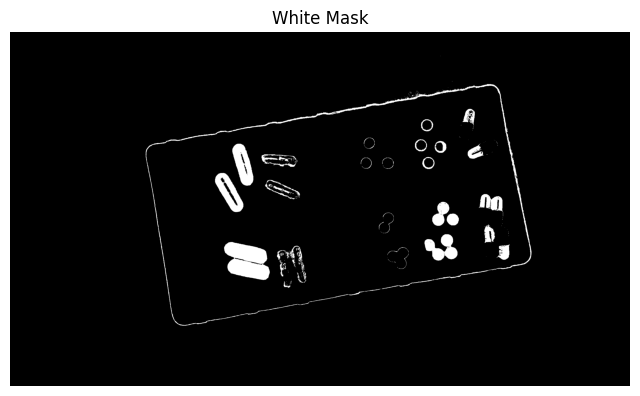

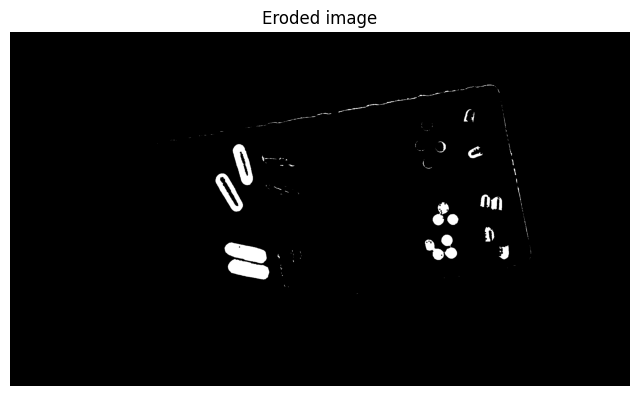

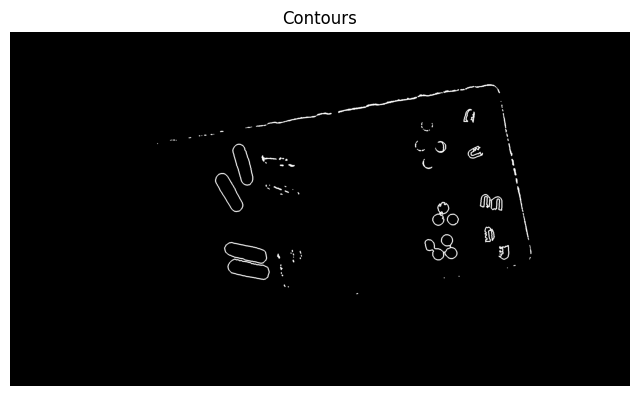

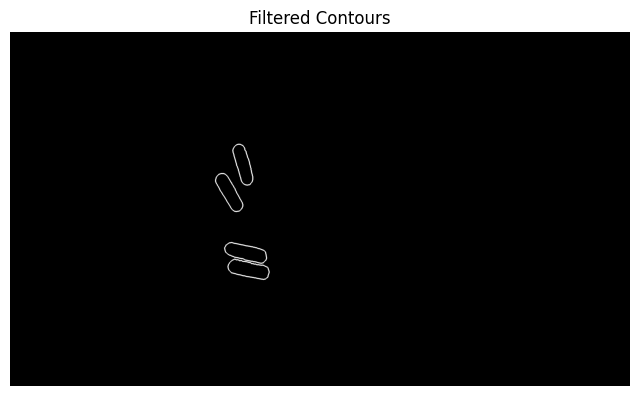

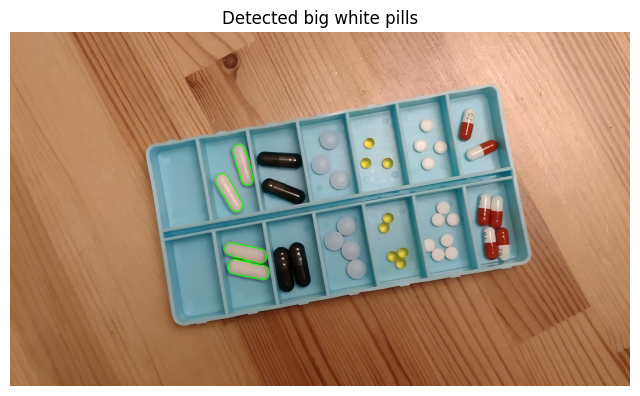

In [9]:
def big_white_pills_binarizer(image: np.ndarray, display: bool = False) -> np.ndarray:
    original_image = image.copy()
    # Konwersja do HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Badanie kanałów
    h_channel, s_channel, v_channel = cv2.split(image_hsv)

    if display:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(h_channel, cmap="gray")
        plt.title("Hue Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(s_channel, cmap="gray")
        plt.title("Saturation Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(v_channel, cmap="gray")
        plt.title("Value Channel")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

    # Maska
    lower = np.array([10, 0, 0])
    upper = np.array([50, 80, 220])
    white_mask = cv2.inRange(image_hsv, lower, upper)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(white_mask, cmap="gray")
        plt.title("White Mask")
        plt.axis("off")
        plt.show()
    image = white_mask

    # Apply erosion
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.erode(image, kernel, iterations=2)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap="gray")
        plt.title("Eroded image")
        plt.axis("off")
        plt.show()
    
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if display:
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, contours, -1, (255, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        plt.title("Contours")
        plt.axis("off")
        plt.show()

    # Filtrowanie konturów na podstawie ich obszaru
    min_area = 8000
    filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt)]
    if display:
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        plt.title("Filtered Contours")
        plt.axis("off")
        plt.show()

    if display:
        cv2.drawContours(original_image, filtered_contours, -1, (0, 255, 0), 3)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected big white pills")
        plt.axis("off")
        plt.show()

    return filtered_contours


probio = create_pills_from_contours(big_white_pills_binarizer(calib, True), PillType.PROBIO)

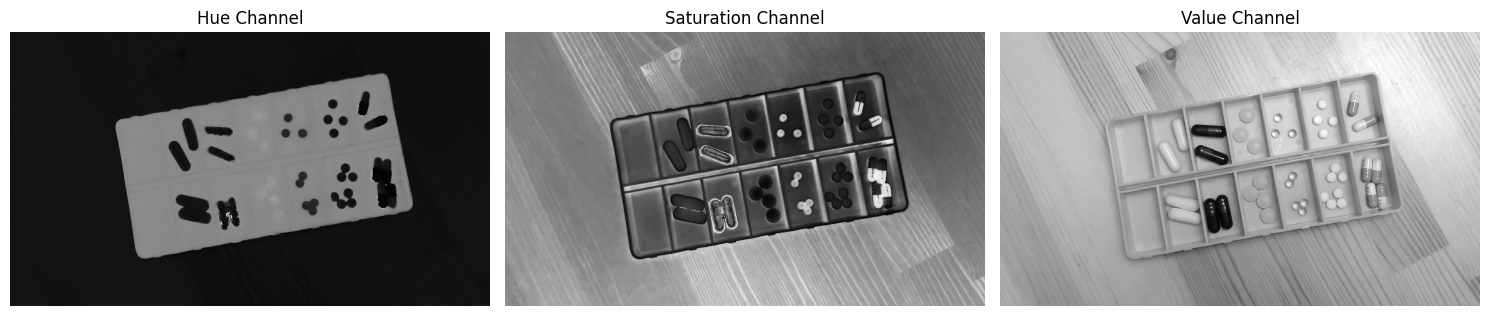

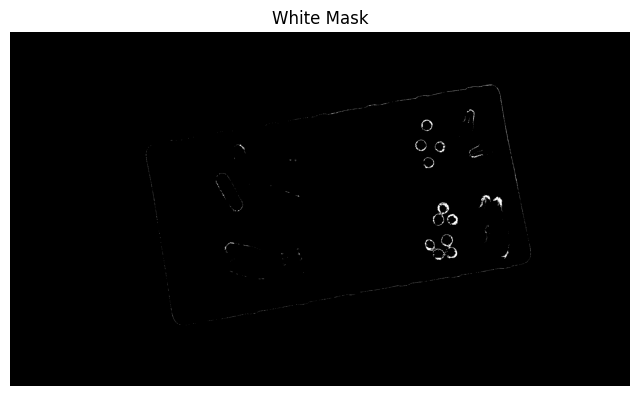

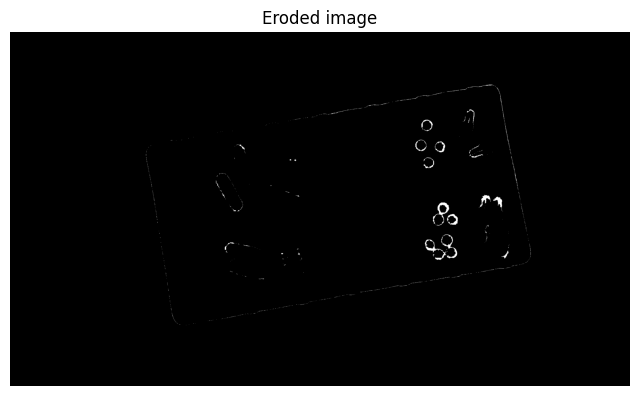

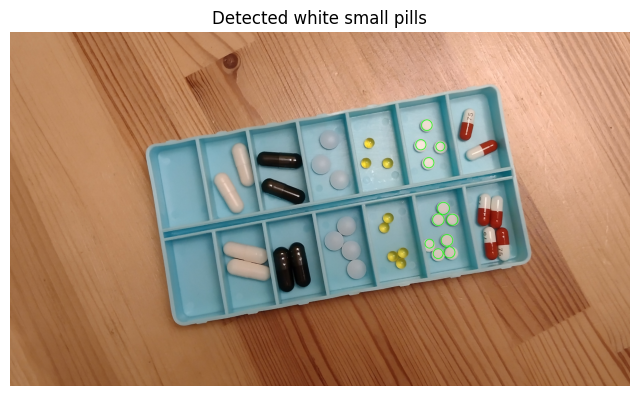

In [13]:
def small_white_pills_binarizer(image: np.ndarray, display: bool = False) -> np.ndarray:
    # Konwersja do przestrzeni HSV
    orginal_image = image.copy()
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Badanie kanałów
    h_channel, s_channel, v_channel = cv2.split(image_hsv)

    if display:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(h_channel, cmap="gray")
        plt.title("Hue Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(s_channel, cmap="gray")
        plt.title("Saturation Channel")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(v_channel, cmap="gray")
        plt.title("Value Channel")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()


    # Maska
    lower_blue = np.array([13, 0, 0])
    upper_blue = np.array([18, 25, 255])
    blue_mask = cv2.inRange(image_hsv, lower_blue, upper_blue)
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(blue_mask, cmap="gray")
        plt.title("White Mask")
        plt.axis("off")
        plt.show()
    image = blue_mask


    # Apply erosion
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.dilate(image, kernel, iterations=2)
    image = cv2.erode(image, kernel, iterations=2)
    
    if display:
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap="gray")
        plt.title("Eroded image")
        plt.axis("off")
        plt.show()

    
    # transformacja Hougha
    circles = cv2.HoughCircles(
        image,
        cv2.HOUGH_GRADIENT,
        dp=1.5,
        minDist=20,
        param1=5,
        param2=30,
        minRadius=10,
        maxRadius=38,
    )

    detected_circles = []  # Lista wykrytych okręgów

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for x, y, r in circles:
            detected_circles.append((x, y, r))  # Przechowywanie środka i promienia okręgu

        # Wizualizacja wykrytych okręgów
        if display:
            output_image = orginal_image
            for x, y, r in detected_circles:
                cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Rysowanie okręgu
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
            plt.title("Detected white small pills")
            plt.axis("off")
            plt.show()


    # Transform circles to contour
    contours = []
    for x, y, r in circles:
            # Create a circular contour
            contour = np.array(
                [
                    [x + r * np.cos(theta), y + r * np.sin(theta)]
                    for theta in np.linspace(0, 2 * np.pi, 100)
                ],
                dtype=np.int32,
            )
            contours.append(contour)

    return contours


biox = create_pills_from_contours(small_white_pills_binarizer(calib, True), PillType.BIOX)
